In [1]:
# Defining targer for ZeMA dataset. 
# Target is vector with numbers from 0 to 100 which represent degree of wear.
def zemaTarget():
    target=list(np.zeros(6291))          # Making the target list which takes into account number of cycles, which-
    for i in range(6291):                # goes from 0 to 100, and has number of elements same as number of cycles. 
        target[i]=(i/6290)*100
    return(target)

In [2]:
# Splits the raw ZeMA data into trening and testing sets.

def splitZemaData(sensors, target):

    k = int(input("Enter the percentage which will be used as a traning data (recommended is 80-90): "))
    target_train, target_test =train_test_split(pd.DataFrame(target), test_size=1-k/100.)

    print("\nNumber of cycles selected for traning is: ", target_train.shape[0],",")
    print("and number of cycles selected for testing is: ", target_test.shape[0])

    sensors_train=[0]*11
    sensors_test=[0]*11

    for i in range(11):
        sensors_train[i]=sensors[i].loc[:,target_train.index]

    print("\n\nTraning data for one sensor has dimensions: ", sensors_train[10].shape,",      ('sensor_train') ")
    print("and it's target vector has length: ", target_train.shape,",               ('target_train_vector') \n")

    for i in range(11):
        sensors_test[i]=sensors[i].loc[:,target_test.index]

    print("Testing data for one sensor has dimensions: ", sensors_test[10].shape,",      ('sensor_test') ")
    print("and it's target vector has length: ", target_test.shape,",               ('target_test_vector') \n")
    
    return sensors_train, sensors_test, target_train, target_test;

In [3]:
# Transforms the target to make classes in them. 
# Classes are integers from 0 to 100.

def zemaClassTarget(target_train, target_test):
    
    # Definition of new target with rounding to first higher number.
    class_target_train=np.ceil(target_train[0])

    for i in class_target_train.index:
        if class_target_train[i]==0:
            class_target_train[i]=1                #Fixing the zero element.
            
    # Clustering the testing data target vector for comparing and error calculation.  
    class_target_test=np.ceil(target_test[0])

    for i in class_target_test.index:
        if class_target_test[i]==0:
            class_target_test[i]=1                   #Fixing the zero element.
    
    return  class_target_train, class_target_test

## Feature extraction
### Feature extraction using BFC

###### Steps:  
    
- transformation into frequency domain (FFT)
- choose amplitudes with highest average absolute value (the top 10%)


In this method of feature extraction, data is transformed into frequency domain using FFT function for discrete Fourier transform.

This step an unsupervised extraction method (i.e. is done without knowledge of the cycle‘s group affiliation) and used is to reduce dimension for further steps.


###### Function input: 

- data from one senzor `sensor : DataFrame, shape (n_samples_in_measurement_cycle, n_measurement_cycles)`,                                 
- timestep between measurement  `timestep`,                                    
- percentage of data to choose `N`.

Function does fast Fourier transform and chooses N% of sprectrum with highest average of absolute values for each sensor independently. Average of absolute values for one frequency is calculated through all cycles. Column names in `sensor` should represent labels for measurement cycles.                                  


###### Function returns:

- `sorted_ampl_with_freq : DataFrame, shape (n_measurement_cycles, N% of features (fequencies))` where row represent one cycle and columns are sorted by the average of absolute vales for each frequency (column). Column names are labels for fequencies. Indexes are labels for measurement cycles.

In [4]:
def chooseAndReturnOrdered(sensor, timestep, N):
    
    n_of_samples=sensor.shape[0]
    
    # Fast Fourier transform
    freq = np.fft.rfftfreq(n_of_samples, timestep)       # Frequency axis, can be used for ploting in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor,n_of_samples,0)  # Ndarray of amplitudes after fourier transform.
    
    # Transforming amplitudes into data frame (matrix)-
    # -where one column represents amplitudes of one-
    # -cycle.
    fft_matrix = pd.DataFrame(fft_amplitudes)            
    
    # Transposing to matrix where rows are cycles.
    fft_matrix=fft_matrix.transpose()                     

    n_rows, n_columns = np.shape(fft_matrix)
    print("\nNumber of cycles is: %s, and number of features after fft is: %s" % (n_rows, n_columns))

    # Index labels are cycle numbers.
    fft_matrix.index=sensor.columns
    
    # Column labels are frequencies.
    fft_matrix.columns = freq                             

    # Calculating the average of absolute vales for each frequency (column).
    absolute_average_values_from_columns=(np.abs(fft_matrix)).mean()

    # Sorting the fft_matrix by the average of absolute vales for each frequency (column).
    fft_matrix=fft_matrix.reindex((np.abs(fft_matrix)).mean().sort_values(ascending=False).index, axis=1)

    # Taking first N percent columns from sorted fft_matrix. 
    sorted_ampl_with_freq=fft_matrix.iloc[:,:round((N/100.0)*len(freq))]

    n_rows, n_columns = np.shape(sorted_ampl_with_freq)
    print("\nNumber of cycles is: %s, and number of selected features is: %s" % (n_rows, n_columns))
    print("---------------------------------------------------------------------------------\n")

    return  sorted_ampl_with_freq;

### Generalization of previous function for list of Data Frames

In [5]:
def chooseFromListOfMatrices (sensors, timestep, N):
    list_of_sorted_ampl_with_freq=[0]*len(sensors)
    
    for i in range(len(sensors)):
        print("Sensor number %s" % i)
        print("---------------------------------------------------------------------------------")
        list_of_sorted_ampl_with_freq[i]=chooseAndReturnOrdered(sensors[i], timestep, N)
    return list_of_sorted_ampl_with_freq;

## Feature selection
### Feature selection using Pearson correlation coefficients

###### Function input: 

- `list_of_sorted_ampl_with_freq : list of DataFrames, shape (n_samples_in_measurement_cycle, N% of features (fequencies))`,                                 
- target vector for traning set  `target_train: DataFrame, shape (n_samples_in_measurement_cycle,1)`,                                    

Function finds indices for features with biggest Pearson correlation to the target from all dataframes in the list.
Firstly, correlation coefficients are calculated for all features and their values are stored in the list `corr`. Then, function called `largest_indices` finds indices for wanted amount of features with highest correlation coefficients. Function output is stored into lists 'sensor_n' and 'feature_n', where element in 'sensor_n' means which sensor, and related element in 'feature_n' means which feature of that sensor is accessed.


###### Function returns:

- `sensor_n` - sensor indices for 500 best features 
- `feature_n` - indices of features of sensor defined by `sensor_n`

In [6]:
def findPearsonIndices(list_of_sorted_ampl_with_freq, target_train, n_of_top_features):
    n_features_for_select=0
    for i in range(len(list_of_sorted_ampl_with_freq)):
        n_features_for_select=n_features_for_select+int(len(list_of_sorted_ampl_with_freq[i].iloc[0][:]))

    print("\nDimension of target is:")
    print("                                                 ", target_train.shape)
    print("Dimension of amplitude matrix for one sensor is:")
    print("                                                 ", list_of_sorted_ampl_with_freq[0].iloc[:][:].shape)

    corr=list(range(len(list_of_sorted_ampl_with_freq)))          # Making list for correlation coefficients.
    p_value=list(range(len(list_of_sorted_ampl_with_freq)))
    
    for j in range(len(list_of_sorted_ampl_with_freq)):               # Making sublists in "corr" for each sensor.
        corr[j]=list(range(list_of_sorted_ampl_with_freq[j].shape[1]))
        p_value[j]=list(range(list_of_sorted_ampl_with_freq[j].shape[1]))

    # Calculating correlation coefficients for each column of each sensor with respect to target.
    for j in range(len(list_of_sorted_ampl_with_freq)):
        for i in range(list_of_sorted_ampl_with_freq[j].shape[1]):
            corr[j][i],p_value[j][i]=pearsonr(np.abs(list_of_sorted_ampl_with_freq[j].iloc[:,i]),target_train[0])
    
    corr_array=np.array(corr)               # Transforming list of correlation coefficients to nparray

    print("Array of correlation coefficients has size:")
    print("                                                 ",corr_array.shape)  

    def largest_indices(array, n):                               # Function that find indices for 500 biggest Pearson-
        """Returns the n largest indices from a numpy array."""  # -correlation coefficients.
        flat = array.flatten()
        indices = np.argpartition(flat, -n)[-n:]
        indices = indices[np.argsort(-flat[indices])]
        return np.unravel_index(indices, array.shape)  

    # sensor_n is the index of the sensor number.
    # feature_n is the index of the feature number for each sensor number.
    sensor_n, feature_n = largest_indices(corr_array,  n_of_top_features)

    print("Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
    print(sensor_n)
    print("\nColumn indices of location of features in >sorted_values_from_all_sensors< matrix: \n")
    print(feature_n)

    return sensor_n, feature_n;

In [7]:
# This function uses indices from sensor_n and feature_n to extract features from list_of_sorted_ampl_with_freq.

def extractTopN(list_of_sorted_ampl_with_freq, sensor_n, feature_n):
    top_n_features=[0]*len(list_of_sorted_ampl_with_freq)
    
    for i in range(len(list_of_sorted_ampl_with_freq)):
        top_n_features[i]=[]
    
    for i in range(len(list_of_sorted_ampl_with_freq)):
        for j in range(len(sensor_n)):
            if sensor_n[j]==i:
                top_n_features[i].append(list_of_sorted_ampl_with_freq[i].iloc[:,feature_n[j]]);

    for i in range(len(list_of_sorted_ampl_with_freq)):
        for j in range(len(top_n_features[i])):
            top_n_features[i][j]=list(top_n_features[i][j])

    # Merging sublists into one list with all elements.
    top_n_together=[j for i in top_n_features for j in i]  

    top_n_together_matrix=np.transpose(pd.DataFrame(top_n_together))
    print(type(top_n_together_matrix), "\n")

    # Continue working with abosulte values.
    abs_top_n_features=np.abs(top_n_together_matrix)

    percentage=list(range(len(list_of_sorted_ampl_with_freq)))
    k=0
    for i in range(len(list_of_sorted_ampl_with_freq)):
        print("Number of features from sensor %2.0f is: %3.0f or  %4.2f %%" % (i, len(top_n_features[i]), len(top_n_features[i])/len(sensor_n)*100))
        percentage[i]=len(top_n_features[i])
        k=k+len(top_n_features[i])/len(sensor_n)*100
    print("----------------------------------------------------")
    print("                                             %4.2f" % (k))

    labels = 'Microphone','Vibration plain bearing','Vibration piston rod','Vibration ball bearing', 'Axial force','Pressure','Velocity','Active current','Motor current phase 1','Motor current phase 2','Motor current phase 3'
    print("Percentages of features from each sensor are:")

    fig1, ax1 = plt.subplots(figsize=(8,8))
    ax1.pie(percentage, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, )
    ax1.axis('equal')

    plt.show()
    
    return abs_top_n_features

## Applying extraction patterns to testing data.

If we have one sensor, i.e. one matrix of features, we can use `extractFromTesting()`, and for list of matrices we use `extractFromListOfTestingMatrices()`.

`sensor_test` is DataFrame from which we will extract;
`sorted_ampl_with_freq` is giving information about frequencies to be extracted.

In [8]:
#Extracting features from test data with predefined frequencies.

def extractFromTesting(sensor_test, sorted_ampl_with_freq, timestep):
    
    n_of_samples=sensor_test.shape[0]
    
    # Fast Fourier transform
    freq = np.fft.rfftfreq(n_of_samples, timestep)            # Frequency axis, can be used for ploting in frequency domain.
    fft_amplitudes = np.fft.rfft(sensor_test,n_of_samples,0)  # Ndarray of amplitudes after fourier transform.
  
    fft_matrix = pd.DataFrame(fft_amplitudes)             
                                                          
    fft_matrix=fft_matrix.transpose()                     # Transposing to matrix where rows are cycles.

    n_rows, n_columns = np.shape(fft_matrix)

    print("\nNumber of cycles is: %s, and number of features is: %s \n" % (n_rows, n_columns))
    fft_matrix.columns = freq                    # Column labels are frequencies.
    
    print("Frequencies are the same as in the traning data, of course. \nFirst 10 of them:\n\n %s" % sorted_ampl_with_freq.columns.values[:10])
    
    sorted_values_matrix_test=fft_matrix.loc[:, sorted_ampl_with_freq.columns.values]

    n_rows, n_columns = np.shape(sorted_values_matrix_test)
    print("\nNumber of cycles is: %s, and number of selected features is: %s \n\n" % (n_rows, n_columns))
    
    return sorted_values_matrix_test;


In [9]:
def extractFromListOfTestingMatrices (sensors_test,list_of_sorted_ampl_with_freq, timestep):

    list_of_sorted_ampl_test=[0]*len(sensors_test)
    
    for i in range(len(sensors_test)):         
        print("Sensor number %s" % i)
        print("---------------------------------------------------------------------------------")
        list_of_sorted_ampl_test[i]=extractFromTesting(sensors_test[i], list_of_sorted_ampl_with_freq[i], 0.005)
    
    return list_of_sorted_ampl_test;

In [10]:
def LDA_Classify(abs_top_n_features, abs_top_n_test_features, class_target_train, class_target_test):
    X_train = np.array(abs_top_n_features)          # Feature matrix.
    y_train = np.array(class_target_train)          # Target vector.
    print("Training set:\n")
    print(X_train.shape)
    print(y_train.shape)
    
    print("\nTesting set:\n")
    X_test = np.array(abs_top_n_test_features)          # Feature matrix.
    y_test = np.array(class_target_test)         # Target vector.

    print(X_test.shape)
    print(y_test.shape)
    
    LDA1 = LinearDiscriminantAnalysis(n_components=3,priors=None, shrinkage=None, solver='eigen')

    Y_train=LDA1.fit_transform(X_train,y_train)
    
    Y_test=LDA1.transform(X_test)
    
    error_LDA1=np.abs((LDA1.predict(X_test))-y_test[:])
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.stem(y_test[:], error_LDA1, use_line_collection=True,  markerfmt=' ')
    plt.xlabel("Class labels for predicted data", size='18')
    plt.ylabel("class diff [%]", size='18')
    plt.title('Prediction error - real and predicted class difference', size='22')

    rmse_lda=sqrt(mean_squared_error((LDA1.predict(X_test)),y_test[:]))

    print("Root mean squared error of classification is:", rmse_lda, " %.\n")

    print("Overall score of LDA predict is: %s" % LDA1.score(X_test, y_test))

    print("\n\nError is showed as a function of real class for all %s testing cycles." % (y_test[:].shape))
    plt.subplot(222)
    plt.scatter(y_test[:], LDA1.predict(X_test))
    plt.xlabel("Real class", size='18')
    plt.ylabel("Predicted class", size='18')
    
    plt.subplot(223)
    plt.title("First two disriminant functions for testing data",fontsize=18)
    plt.scatter(Y_test[:,0], Y_test[:,1], c=y_test, cmap="viridis")                   
    plt.xlabel("First discriminant function", fontsize=15)
    plt.ylabel("Second discriminant function", fontsize=15)

    plt.colorbar().set_label('% of wear',fontsize=15 ,rotation=90)


# Workflow

In [11]:
import h5py                                     # Importing the h5 package.
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from math import sqrt
from sklearn.metrics import mean_squared_error

### Importing the data

In [12]:
filename = 'Sensor_data_2kHz.h5'                # Data filename.
f = h5py.File(filename, 'r')                    # Importing the h5 file. 

#print("Keys: %s" % f.keys())
a_group_key = list(f.keys())[0]

data = list(f[a_group_key])                     # Transforming data into list

sensorADC=[]                                       # Initialising a list "sensor" and
for i in range(11):                                # Filling it with data from all sensors 
    sensorADC.append(pd.DataFrame(data[i][:][:]))

for i in range(11):                             
    sensorADC[i]=sensorADC[i].iloc[:,:6291]           # Cuting the last cycle because it contains all zero elements.

print("""    
    Input matrices have dimensions: %s, where %s represents number of measurements in time
    and %s represents number of cycles.""" % (np.shape(sensorADC[0]),np.shape(sensorADC[0])[0],np.shape(sensorADC[0])[1]))


    
    Input matrices have dimensions: (2000, 6291), where 2000 represents number of measurements in time
    and 6291 represents number of cycles.


### Creating a trget (specific for Zema dataset)

In [13]:
target=zemaTarget()

### Splitting the ZeMA dataset..

In [14]:
sensors_train, sensors_test, target_train, target_test=splitZemaData(sensorADC, target)

Enter the percentage which will be used as a traning data (recommended is 80-90): 85

Number of cycles selected for traning is:  5347 ,
and number of cycles selected for testing is:  944


Traning data for one sensor has dimensions:  (2000, 5347) ,      ('sensor_train') 
and it's target vector has length:  (5347, 1) ,               ('target_train_vector') 

Testing data for one sensor has dimensions:  (2000, 944) ,      ('sensor_test') 
and it's target vector has length:  (944, 1) ,               ('target_test_vector') 



### Making categorical target (classes are integers)..

In [15]:
class_target_train, class_target_test=zemaClassTarget(target_train, target_test)

# Traning set.. 

### Best Fourier coefficients method..

In [16]:
list_of_sorted_ampl_with_freq=chooseFromListOfMatrices (sensors_train, 0.005, 10)

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features after fft is: 1001

Number of cycles is: 5347, and number of selected features is: 100
---------------------------------------------------------------------------------

Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features after fft is: 1001

Number of cycles is: 5347, and number of selected features is: 100
---------------------------------------------------------------------------------

Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 5347, and number of features after fft is: 1001

Number of cycles is: 5347, and number of selected features is: 100
---------------------------------------------------------------------------------

Sensor number 3
---------------------------

### Find indices for strongest Pearson correlation 

In [17]:
sensor_indices, feature_indices = findPearsonIndices(list_of_sorted_ampl_with_freq, target_train, 500)


Dimension of target is:
                                                  (5347, 1)
Dimension of amplitude matrix for one sensor is:
                                                  (5347, 100)
Array of correlation coefficients has size:
                                                  (11, 100)
Sensor indices of location of features in >sorted_values_from_all_sensors< matrix: 

[ 7 10 10  8  8  2  9  0  0  1  0  7  2  9  3  2  2  3  3  1  3  3  9  7
  3  5  3  9  0 10  0  0  2  3  0  0  7  5  0  2  0  3  3  9  2  3  3  3
  7  0  2  3  0  2  3  3  3  3  8  3  0  0  3  2  0  2  3  3  3  0  0  9
  2  2  2 10  8  2  2  3  2  7  0  3  3  0  2  3  3  0  3  3  8  1  2  0
 10  2  3  1  3  2  3  3  3  3  9  3  3  0  0  2 10  3  3  2  8 10  3  0
  1  0  3  3  3  7  0  2  0  3  0  9  3  1  3  7  1 10 10  3  9  2  0  2
  1  1  7 10 10  2  2  3  2  5  2  2  2  7  2  3  2  8  0  0  2  9  2  2
  9 10  1  0  2  2  0  2  2  0  2 10  7  2  3  2  8  3  0  7  0  3  2  1
  2  1  2  0  3  3  0  7  2  2 

### Select features using output from previous function.

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  75 or  15.00 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  79 or  15.80 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   8 or  1.60 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   6 or  1.20 %
Number of features from sensor  7 is:  71 or  14.20 %
Number of features from sensor  8 is:  47 or  9.40 %
Number of features from sensor  9 is:  46 or  9.20 %
Number of features from sensor 10 is:  47 or  9.40 %
----------------------------------------------------
                                             100.00
Percentages of features from each sensor are:


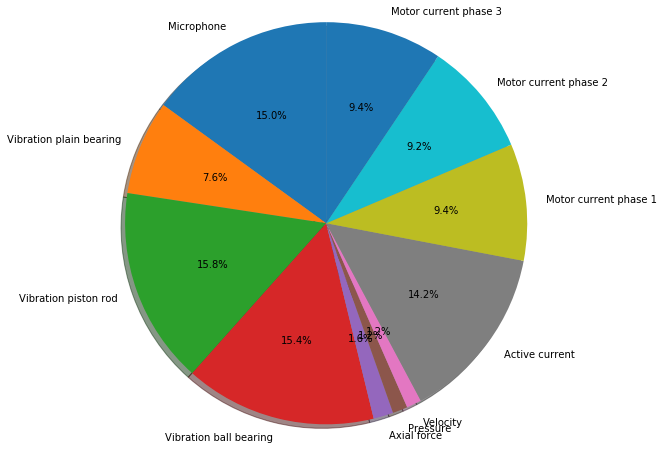

In [18]:
abs_top_n_features=extractTopN(list_of_sorted_ampl_with_freq, sensor_indices, feature_indices)

# Testing set..

Extract the same frequencies selected in traning set.

In [19]:
list_of_sorted_ampl_test=extractFromListOfTestingMatrices (sensors_test,list_of_sorted_ampl_with_freq, 0.005)

Sensor number 0
---------------------------------------------------------------------------------

Number of cycles is: 944, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [ 0.  48.   8.5 64.   0.1 10.  12.   0.2  0.3  0.6]

Number of cycles is: 944, and number of selected features is: 100 


Sensor number 1
---------------------------------------------------------------------------------

Number of cycles is: 944, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [48.   8.  47.9  7.9  0.2 48.1  7.8  0.   4.  12. ]

Number of cycles is: 944, and number of selected features is: 100 


Sensor number 2
---------------------------------------------------------------------------------

Number of cycles is: 944, and number of features is: 1001 

Frequencies are the same as in the traning data, of course. 
First 10 of them:

 [16.1 16.2 12.  16.  16.3 40.6 81.9 

Select the same features selected in traning set.

<class 'pandas.core.frame.DataFrame'> 

Number of features from sensor  0 is:  75 or  15.00 %
Number of features from sensor  1 is:  38 or  7.60 %
Number of features from sensor  2 is:  79 or  15.80 %
Number of features from sensor  3 is:  77 or  15.40 %
Number of features from sensor  4 is:   8 or  1.60 %
Number of features from sensor  5 is:   6 or  1.20 %
Number of features from sensor  6 is:   6 or  1.20 %
Number of features from sensor  7 is:  71 or  14.20 %
Number of features from sensor  8 is:  47 or  9.40 %
Number of features from sensor  9 is:  46 or  9.20 %
Number of features from sensor 10 is:  47 or  9.40 %
----------------------------------------------------
                                             100.00
Percentages of features from each sensor are:


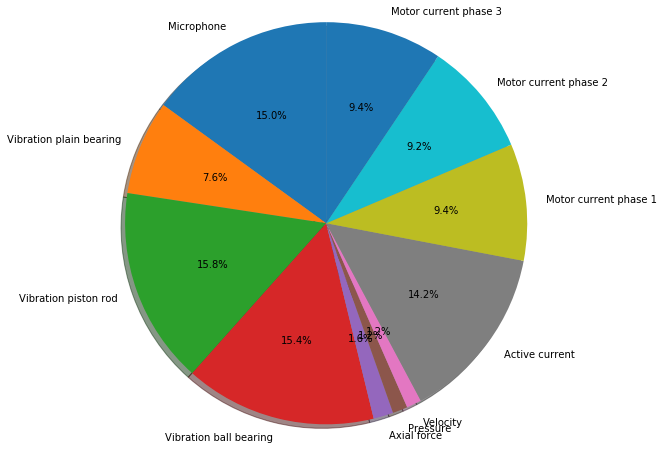

In [20]:
abs_top_n_test_features=extractTopN(list_of_sorted_ampl_test, sensor_indices, feature_indices)

# Classification with LDA...

Training set:

(5347, 500)
(5347,)

Testing set:

(944, 500)
(944,)
Root mean squared error of classification is: 0.5992580157924676  %.

Overall score of LDA predict is: 0.8432203389830508


Error is showed as a function of real class for all 944 testing cycles.


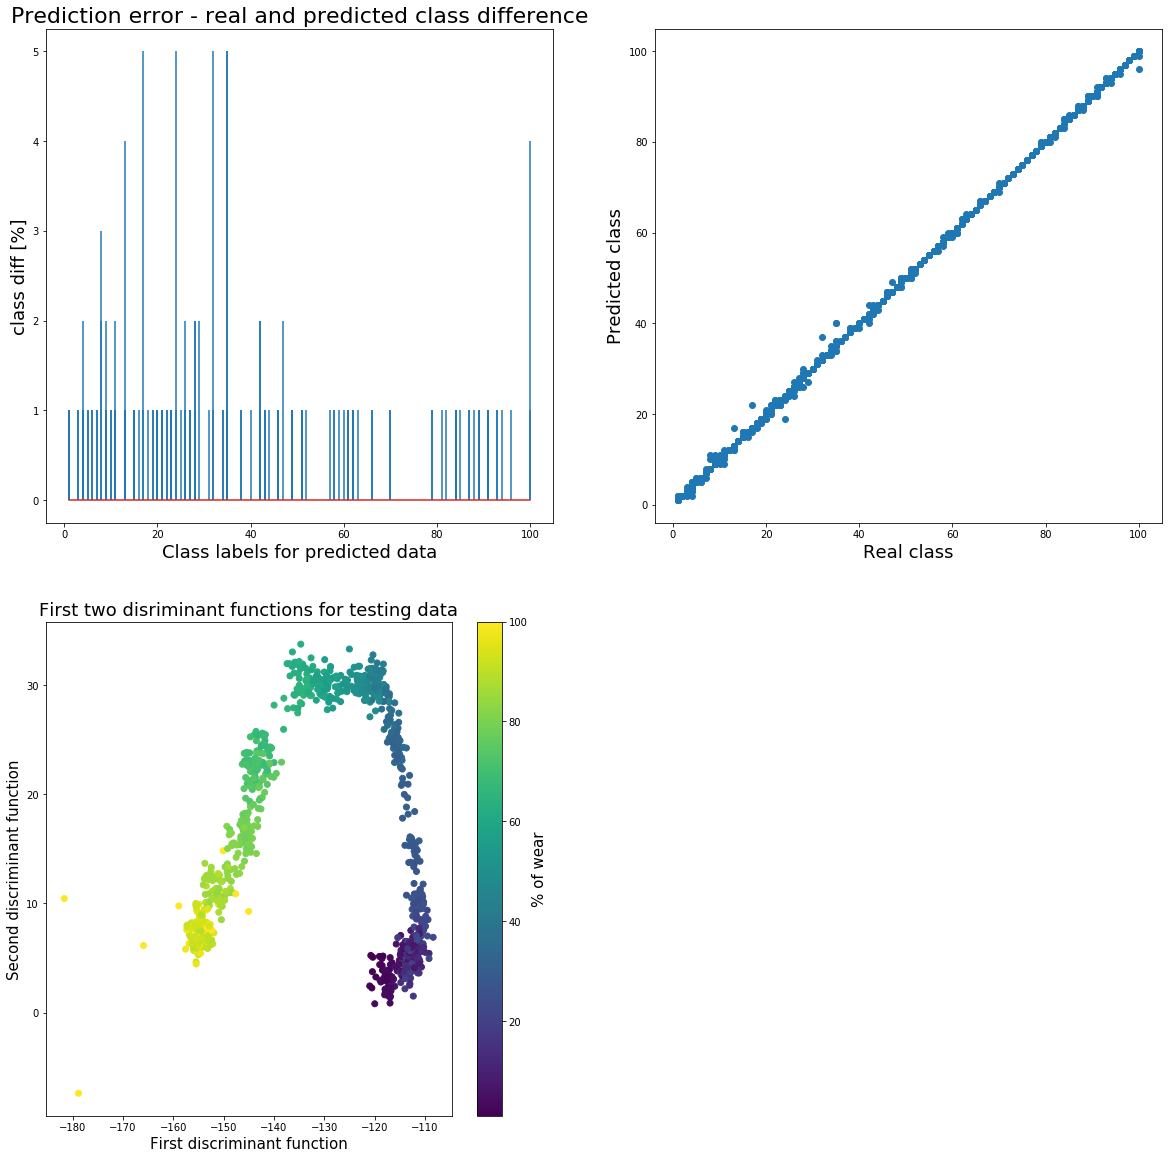

In [21]:
LDA_Classify(abs_top_n_features, abs_top_n_test_features, class_target_train, class_target_test)